In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

In [2]:
from lib.sim_data_i3 import I3SimHandlerFtr
from lib.network import TriplePandleNet
from lib.plotting_tools import plot_event, adjust_plot_1d
from time_sampler import sample_times

2024-05-22 14:33:49.133423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [4]:
# Get a simulated muon event.

event_index = 5
meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 3.4 TeV
n_doms 43


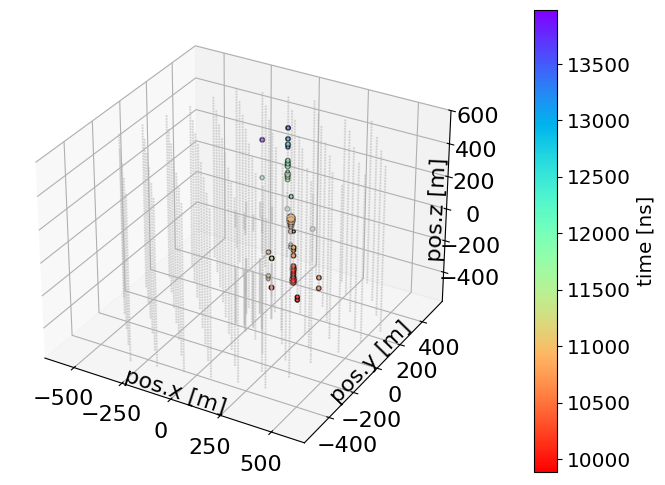

In [5]:
plot_event(event_data, geo=sim_handler.geo)

In [13]:
# Let's generate some new first hit times following our triple pandel model.
# (avoid problems with time smearing for now -> to be implemented: gaussian convoluted triple pandel.)

track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

network = TriplePandleNet('./data/network/')

In [14]:
# Compute position of muon at the time of the highest charge dom hit.
# or use charge weighted mean of first hit

print("old track vertex:", track_pos)

from lib.geo import get_xyz_from_zenith_azimuth
from lib.geo import __c
#idx = np.argmax(event_data['charge'])
#centered_track_time = event_data.iloc[idx]['time']
centered_track_time = np.sum(event_data['charge'] * event_data['time']) / np.sum(event_data['charge'])
centered_track_pos = track_pos + (centered_track_time - track_time) * __c * get_xyz_from_zenith_azimuth(track_src)
print("new track vertex:", centered_track_pos)

centered_track_time = jnp.float64(centered_track_time)
centered_track_pos = jnp.array(centered_track_pos)

old track vertex: [ 143.40123598  106.94081331 -815.20509865]
new track vertex: [ -25.42355091  403.14288541 -154.63778486]


In [15]:
key = jax.random.PRNGKey(2)

In [11]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fake_event_data = jnp.column_stack([jnp.array(event_data[['x', 'y', 'z']].to_numpy()), 
                                    jnp.array(first_times), 
                                    jnp.array(n_photons)])
print(fake_event_data.shape)

# Send to GPU.
fake_event_data.devices()
centered_track_pos.devices()
centered_track_time.devices()
track_src.devices()

(43, 5)


{cuda(id=0)}

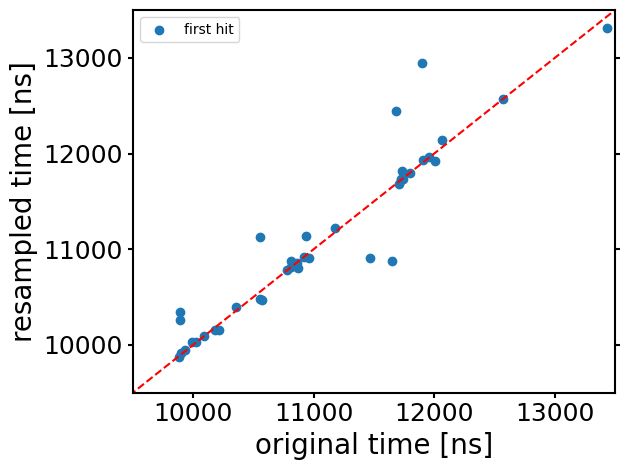

In [16]:
key, subkey = jax.random.split(key)
first_times = sample_times(event_data, track_pos, track_src, track_time, network, subkey)

# compare to original first hit times
fig, ax = plt.subplots()
ax.scatter(event_data['time'], first_times, label='first hit')
plt.plot([0, 100000], [0, 100000], "r--")

plot_args = {'xlim':[9500, 13500],
                 'ylim':[9500, 13500],
                 'xlabel':'original time [ns]',
                 'ylabel':'resampled time [ns]'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [17]:
%timeit sample_times(event_data, track_pos, track_src, track_time, network, subkey).block_until_ready()

810 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
def get_network_eval_fn(bpath: str = '../../data/network/', n_layer=9):
        """
        """
        params = []

        for i in range(0, n_layer):
            layer_weights = np.load(os.path.join(bpath, f'dense_{i}_weights.npy'))
            layer_bias = np.load(os.path.join(bpath, f'dense_{i}_bias.npy'))
            params.append((jnp.array(layer_weights), jnp.array(layer_bias)))

        params = tuple(params)

        @jax.jit
        def _eval_network(x):
            """
            """
        
            x = jnp.tanh(jnp.dot(x, params[0][0]) + params[0][1])
        
            # residual block 1
            y = jnp.tanh(jnp.dot(x, params[1][0]) + params[1][1])
            y = jnp.tanh(jnp.dot(y, params[2][0]) + params[2][1])
            x = jnp.tanh(jnp.dot(y, params[3][0]) + params[3][1]) + x
        
            # residual block 2
            y = jnp.tanh(jnp.dot(x, params[4][0]) + params[4][1])
            y = jnp.tanh(jnp.dot(y, params[5][0]) + params[5][1])
            x = jnp.tanh(jnp.dot(y, params[6][0]) + params[6][1]) + x
        
            # outputs
            y = jnp.tanh(jnp.dot(x, params[7][0]) + params[7][1])
            z = jnp.dot(y, params[8][0]) + params[8][1]
            return z

        return _eval_network

In [13]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_v = jax.jit(jax.vmap(eval_network, 0, 0))

In [17]:
from lib.geo import cherenkov_cylinder_coordinates_v
from lib.geo import rho_dom_relative_to_track_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs_v, transform_network_inputs_v

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [18]:
def get_neg_llh(eval_network_fn, event_data, track_vertex, track_time, eps=jnp.float64(1.e-20)):

    @jax.jit
    def neg_mpe_llh_direction_const_vertex2(track_direction):
        """
        track_direction: (zenith, azimuth) in radians
        track_vertex: (x, y, z)
        track_time: t (this time defines the fit vertex)
        event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
        """
        print(track_direction)
        
        dom_positions = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        n_photons = event_data[:, 4]
    
        track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
        
        geo_time, closest_approach_dist, closest_approach_z = \
        cherenkov_cylinder_coordinates_v(dom_positions,
                                         track_vertex,
                                         track_dir_xyz)
    
        closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, 
                                                           track_vertex, 
                                                           track_dir_xyz)
    
        track_zenith = track_direction[0]
        track_azimuth = track_direction[1]
        x = jnp.column_stack([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          jnp.repeat(track_zenith, len(closest_approach_dist)),
                          jnp.repeat(track_azimuth, len(closest_approach_dist))])
    
        x_prime = transform_network_inputs_v(x)
        y_pred = eval_network_fn(x_prime)
        logits, av, bv = transform_network_outputs_v(y_pred)
    
        gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=av,
                    rate=bv,
                    force_probs_to_zero_outside_support=True
                      )
                )
    
        delay_time = first_hit_times - (geo_time + track_time)
        llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
        llh = llh + eps
        return -2*jnp.sum(llh)

    return neg_mpe_llh_direction_const_vertex2

In [19]:
neg_llh = get_neg_llh(eval_network_v, fake_event_data, centered_track_pos, centered_track_time)
neg_llh_v = jax.jit(jax.vmap(neg_llh, 0, 0))

(200, 200)
Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=3/0)>


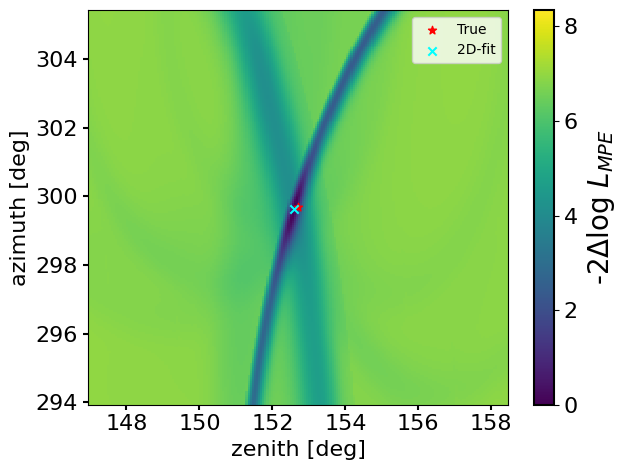

In [20]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
X, Y = np.meshgrid(zenith, azimuth)
print(X.shape)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh_v(init_dirs) 

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")
#ax.scatter(np.rad2deg(meta['spline_mpe_zenith']), np.rad2deg(meta['spline_mpe_azimuth']), marker="x", color='cyan', label="SplineMPE")
ax.scatter(np.rad2deg([2.66320856]), np.rad2deg([5.22943805]), marker="x", color='cyan', label='2D-fit')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
%timeit neg_llh_v(init_dirs).block_until_ready()

1.55 s ± 151 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
import jaxopt
solver_2 = jaxopt.LBFGS(fun=neg_llh, 
                        maxiter=1000, 
                        max_stepsize=1.e-3)

solver_2_sol = solver_2.run(jnp.array(track_src))
print(solver_2_sol.params)

[2.66307258 5.23008076]


In [23]:
solver_1 = jaxopt.ScipyMinimize(method = "bfgs", fun=neg_llh, tol = 1e-5, maxiter=1000, 
                                options = {'xrtol':1.e-5})

solver_1_sol = solver_1.run(jnp.array(track_src))
print(solver_1_sol.params)

[2.66320856 5.22943805]


In [25]:
%timeit solver_1.run(jnp.array(track_src))

75.3 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
def get_eval_network_doms_and_track(eval_network_v_fn):
    """
    network eval function (vectorized across doms)
    """
    
    @jax.jit
    def eval_network_doms_and_track(dom_pos, track_vertex, track_dir):
        """
        track_direction: (zenith, azimuth) in radians
        track_vertex: (x, y, z)
        dom_pos: 2D array (n_doms X 3) where columns are x,y,z of dom location
        """
        track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
        
        geo_time, closest_approach_dist, closest_approach_z = \
        cherenkov_cylinder_coordinates_v(dom_positions,
                                         track_vertex,
                                         track_dir_xyz)
    
        closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, 
                                                           track_vertex, 
                                                           track_dir_xyz)
    
        track_zenith = track_direction[0]
        track_azimuth = track_direction[1]
        x = jnp.column_stack([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          jnp.repeat(track_zenith, len(closest_approach_dist)),
                          jnp.repeat(track_azimuth, len(closest_approach_dist))])
    
        x_prime = transform_network_inputs_v(x)
        y_pred = eval_network_v_fn(x_prime)
        logits, av, bv = transform_network_outputs_v(y_pred)
        return logits, av, bv

    return eval_network_doms_and_track

In [29]:
def get_neg_llh2(eval_network_v_fn, event_data, track_vertex, track_time, eps=jnp.float64(1.e-20)):

    eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v_fn)
    
    @jax.jit
    def neg_mpe_llh_direction_const_vertex2(track_direction):
        """
        track_direction: (zenith, azimuth) in radians
        track_vertex: (x, y, z)
        track_time: t (this time defines the fit vertex)
        event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
        """
        print(track_direction)
        
        dom_pos = event_data[:, :3]
        logits, av, bv = eval_network_doms_and_track(dom_pos, track_vertex, track_direction)
    
        gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=av,
                    rate=bv,
                    force_probs_to_zero_outside_support=True
                      )
                )
        
        first_hit_times = event_data[:, 3]
        n_photons = event_data[:, 4]
    
        delay_time = first_hit_times - (geo_time + track_time)
        llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
        llh = llh + eps
        return -2*jnp.sum(llh)

    return neg_mpe_llh_direction_const_vertex2

In [30]:
neg_llh2 = get_neg_llh(eval_network_v, fake_event_data, centered_track_pos, centered_track_time)

In [32]:
neg_llh2_v = jax.jit(jax.vmap(neg_llh2, 0, 0))

(200, 200)
Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=3/0)>


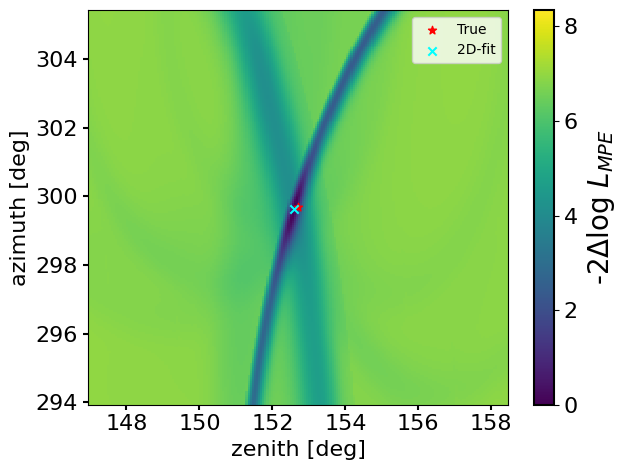

In [33]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
X, Y = np.meshgrid(zenith, azimuth)
print(X.shape)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh2_v(init_dirs) 

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")
#ax.scatter(np.rad2deg(meta['spline_mpe_zenith']), np.rad2deg(meta['spline_mpe_azimuth']), marker="x", color='cyan', label="SplineMPE")
ax.scatter(np.rad2deg([2.66320856]), np.rad2deg([5.22943805]), marker="x", color='cyan', label='2D-fit')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
%timeit neg_llh2_v(init_dirs) 

1.55 s ± 148 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
from dom_track_eval import get_eval_network_doms_and_track
from lib.network import get_network_eval_v_fn
from time_sampler import sample_times_clean

In [6]:
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

In [7]:
# Let's generate some new first hit times following our triple pandel model.
# (avoid problems with time smearing for now -> to be implemented: gaussian convoluted triple pandel.)

track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

In [8]:
# Compute position of muon at the time of the highest charge dom hit.
# or use charge weighted mean of first hit

print("old track vertex:", track_pos)

from lib.geo import get_xyz_from_zenith_azimuth
from lib.geo import __c
#idx = np.argmax(event_data['charge'])
#centered_track_time = event_data.iloc[idx]['time']
centered_track_time = np.sum(event_data['charge'] * event_data['time']) / np.sum(event_data['charge'])
centered_track_pos = track_pos + (centered_track_time - track_time) * __c * get_xyz_from_zenith_azimuth(track_src)
print("new track vertex:", centered_track_pos)

centered_track_time = jnp.float64(centered_track_time)
centered_track_pos = jnp.array(centered_track_pos)

old track vertex: [ 143.40123598  106.94081331 -815.20509865]
new track vertex: [ -25.42355091  403.14288541 -154.63778486]


In [9]:
key = jax.random.PRNGKey(2)

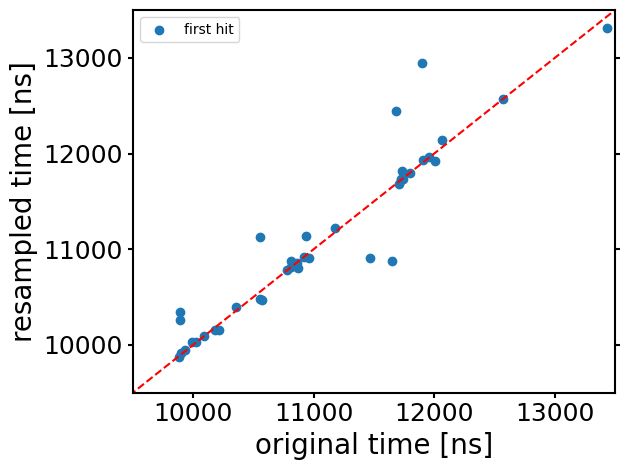

In [10]:
key, subkey = jax.random.split(key)
first_times = sample_times_clean(event_data, track_pos, track_src, track_time, eval_network_doms_and_track, subkey)

# compare to original first hit times
fig, ax = plt.subplots()
ax.scatter(event_data['time'], first_times, label='first hit')
plt.plot([0, 100000], [0, 100000], "r--")

plot_args = {'xlim':[9500, 13500],
                 'ylim':[9500, 13500],
                 'xlabel':'original time [ns]',
                 'ylabel':'resampled time [ns]'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [11]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fake_event_data = jnp.column_stack([jnp.array(event_data[['x', 'y', 'z']].to_numpy()), 
                                    jnp.array(first_times), 
                                    jnp.array(n_photons)])
print(fake_event_data.shape)

# Send to GPU.
fake_event_data.devices()
centered_track_pos.devices()
centered_track_time.devices()
track_src.devices()

(43, 5)


{cuda(id=0)}

In [12]:
%timeit sample_times_clean(event_data, track_pos, track_src, track_time, eval_network_doms_and_track, subkey).block_until_ready()

821 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

def get_neg_llh3(eval_network_doms_and_track_fn, event_data, track_vertex, track_time, eps=jnp.float64(1.e-20)):
    
    @jax.jit
    def neg_mpe_llh_direction_const_vertex2(track_direction):
        """
        track_direction: (zenith, azimuth) in radians
        track_vertex: (x, y, z)
        track_time: t (this time defines the fit vertex)
        event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
        """
        print(track_direction)
        
        dom_pos = event_data[:, :3]
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)
    
        gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=av,
                    rate=bv,
                    force_probs_to_zero_outside_support=True
                      )
                )
        
        first_hit_times = event_data[:, 3]
        n_photons = event_data[:, 4]
    
        delay_time = first_hit_times - (geo_time + track_time)
        llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
        llh = llh + eps
        return -2*jnp.sum(llh)

    return neg_mpe_llh_direction_const_vertex2

In [13]:
neg_llh3 = get_neg_llh3(eval_network_doms_and_track, fake_event_data, centered_track_pos, centered_track_time)
neg_llh3_v = jax.jit(jax.vmap(neg_llh3, 0, 0))

(200, 200)
Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=3/0)>


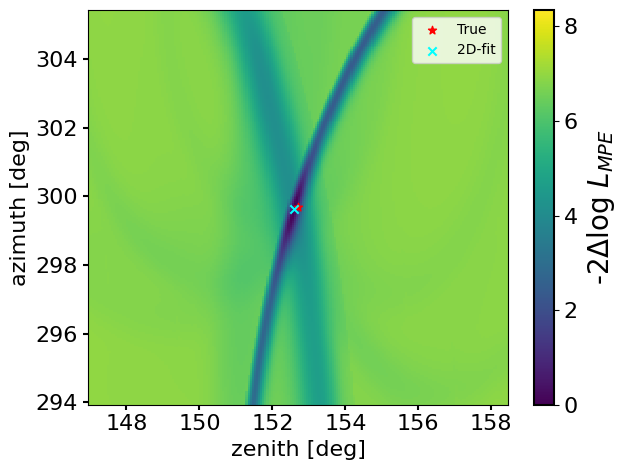

In [14]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
X, Y = np.meshgrid(zenith, azimuth)
print(X.shape)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh3_v(init_dirs) 

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")
#ax.scatter(np.rad2deg(meta['spline_mpe_zenith']), np.rad2deg(meta['spline_mpe_azimuth']), marker="x", color='cyan', label="SplineMPE")
ax.scatter(np.rad2deg([2.66320856]), np.rad2deg([5.22943805]), marker="x", color='cyan', label='2D-fit')
plt.legend()
plt.tight_layout()
plt.show()